In [267]:
import pandas as pd
import datetime
import seaborn as sns
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

ImportError: cannot import name 'cross_validation' from 'sklearn' (C:\Users\a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\__init__.py)

In [26]:
df1 = pd.read_csv('./assets/DOHMH_New_York_City_Restaurant_Inspection_Results_historical.csv')
df = pd.read_csv('./assets/DOHMH_New_York_City_Restaurant_Inspection_Results_03_25_19.csv')

In [27]:
frames = [df1,df]
df = pd.concat(frames)
del(df1)

In [28]:
start = datetime.datetime.now()

df.columns = [i.lower() for i in df.columns]

df.rename(index=str,columns={'cuisine description':'cuisine_description',
                            'inspection date':'inspection_date',
                            'critical flag':'critical_flag',
                            'grade date':'grade_date',
                            'record date':'record_date',
                            'inspection type':'inspection_type',
                            'violation code':'violation_code',
                            'violation description':'violation_description'}, inplace=True)


df['grade_date'] = pd.to_datetime(df['grade_date'],errors='coerce', format='%m/%d/%Y')
df['inspection_date'] = pd.to_datetime(df['inspection_date'],errors='coerce', format='%m/%d/%Y')
df['record_date'] = pd.to_datetime(df['record_date'],errors='coerce', format='%m/%d/%Y')

df['address'] = df['building'] + ' ' + df['street'].str.title()
df.drop(['building','street'],axis=1, inplace=True)
df['dba'] = df['dba'].str.title()
df['boro'] = df['boro'].str.title()

df['key'] = df['camis']+df['inspection_date']

df = df.drop_duplicates(['key','violation_code'])

pending_df = df[df['inspection_date']<'1/1/1901'].copy()
current_df = df[df['inspection_date']>'1/1/1901'].copy()

current_df.sort_values(['camis','inspection_date'], ascending=False, inplace=True)
current_df.reset_index(drop=True,inplace=True)

print('took {} seconds'.format(datetime.datetime.now()-start))

took 0:00:14.815222 seconds


In [29]:
df = current_df

In [30]:
start = datetime.datetime.now()

violation_dictionary = {}
for i in range(len(df)):
    current_code = df.loc[i,'violation_code']
    current_desc = df.loc[i,'violation_description']
    
    if current_code not in violation_dictionary:
        violation_dictionary[current_code] = current_desc
        
print('took {} seconds'.format(datetime.datetime.now()-start))

took 0:00:13.287664 seconds


In [31]:
start = datetime.datetime.now()

violation_df = {}
for i in range(len(df)):
    current_key = df['key'][i]
    current_code = df['violation_code'][i]
    
    if current_key in violation_df:
        violation_df[current_key].append(current_code)
    else:
        violation_df[current_key] = [current_code]
        
codes = []
keys = []
for k,v in violation_df.items():
    keys.append(k)
    codes.append(v)
    
d = {'key':keys,'codes':codes}
insp = pd.DataFrame(d)

print('took {} seconds'.format(datetime.datetime.now()-start))

took 0:00:26.287018 seconds


In [32]:
start = datetime.datetime.now()
df = df.drop_duplicates('key').drop(['violation_code','violation_description','critical_flag'],axis=1)
df = df.merge(insp,on='key')

df.sort_values(['camis','inspection_date'], inplace=True)
df.reset_index(drop=True, inplace=True)

print('took {} seconds'.format(datetime.datetime.now()-start))

took 0:00:01.661445 seconds


In [33]:
df = df[df['inspection_type'].str.contains('Cycle') |
   df['inspection_type'].str.contains('Pre-permit')
  ]

In [34]:
start = datetime.datetime.now()

df.reset_index(inplace=True,drop=True)
s1 = []
next_index = 1

for i in range(len(df)-1):
    current_camis = df.loc[i,'camis']
    next_camis = df.loc[next_index,'camis']
    
    if current_camis == next_camis:
        time_delt = df.loc[next_index,'inspection_date'] - df.loc[i,'inspection_date']
        s1.append(time_delt)
    else:
        s1.append(pd.NaT)
        
    next_index += 1
    
s1.append(pd.NaT)
df['time_til'] = pd.Series(s1)

print('took {} seconds'.format(datetime.datetime.now()-start))

took 0:00:16.837976 seconds


In [35]:
df['event'] = df['time_til'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['time_til'] = df['time_til'].where(pd.notnull(df['time_til']), df['record_date'] - df['inspection_date'])
df['time_til'] = df['time_til'].apply(lambda x: x.days)

In [36]:
df = df[df['time_til']<500]
df.reset_index(drop=True,inplace=True)

In [37]:
start = datetime.datetime.now()

inspection_bin = []

for i in range(len(df)):
    current_type = df.loc[i,'inspection_type']
    current_score = df.loc[i,'score']
    current_camis = df.loc[i,'camis']
    
    if 'Cycle' in current_type:
        if 'Initial' in current_type:
            if current_score < 14:
                inspection_bin.append('cyc_init_0')
            elif current_score > 13:
                inspection_bin.append('cyc_init_1')
                
        elif 'Re-' in current_type:
            previous_score = df.loc[i-1,'score']
            previous_camis = df.loc[i-1,'camis']
            
            if current_camis == previous_camis:
                if previous_score < 14:
                    inspection_bin.append('cyc_re_0')
                elif previous_score > 13 and previous_score < 28:
                    inspection_bin.append('cyc_re_1')
                elif previous_score > 27:
                    inspection_bin.append('cyc_re_2')
            else:
                inspection_bin.append('missing_prior_cycle')
        else:
            inspection_bin.append('other_cycle')
            
            
    elif 'Pre-' in current_type:
        if 'Initial' in current_type:
            if current_score < 14:
                inspection_bin.append('pre_init_0')
            elif current_score > 13:
                inspection_bin.append('pre_init_1')
                
        elif 'Re-' in current_type:
            previous_camis = df.loc[i-1,'camis']
            previous_score = df.loc[i-1,'score']
            
            if current_camis == previous_camis:
                if previous_score < 14:
                    inspection_bin.append('pre_re_0')
                elif previous_score > 13 and previous_score < 28:
                    inspection_bin.append('pre_re_1')
                elif previous_score > 27:
                    inspection_bin.append('pre_re_2')
            else:
                inspection_bin.append('missing_prior_pre')
        else:
            inspection_bin.append('other_pre')
    else:
        inspection_bin.append('weird')
        
print('took {} seconds'.format(datetime.datetime.now()-start))

took 0:00:08.920638 seconds


In [38]:
inspection_bin = pd.Series(inspection_bin)

df['bin'] = inspection_bin
df['season'] = df['inspection_date'].apply(lambda dt: (dt.month%12 + 3)//3)

bin_dummies = pd.get_dummies(df['bin'], drop_first=False)
df = df.join(bin_dummies)

df['day_of_week'] = df['inspection_date'].dt.dayofweek




In [198]:
df['early'] = [(df['time_til']<275) &
        (df['bin'] == 'cyc_init_0') &
        (df['event'] == 1)
][0]



In [52]:
temp_df = pd.read_csv('./assets/DOHMH_New_York_City_Restaurant_Inspection_Results_historical.csv')

In [76]:
code_dummies = pd.get_dummies(temp_df['VIOLATION CODE'], drop_first=False)
# temp_df

In [93]:
d = pd.DataFrame(0, index=np.arange(len(df)), columns=code_dummies.columns)
df_copy = df.copy()


In [102]:
d = d.join(df_copy)

In [122]:
code_dummies.columns

Index(['02A', '02B', '02C', '02D', '02E', '02F', '02G', '02H', '02I', '02J',
       '03A', '03B', '03C', '03D', '03E', '03F', '03G', '04A', '04B', '04C',
       '04D', '04E', '04F', '04G', '04H', '04I', '04J', '04K', '04L', '04M',
       '04N', '04O', '05A', '05B', '05C', '05D', '05E', '05F', '05H', '05I',
       '06A', '06B', '06C', '06D', '06E', '06F', '06G', '06H', '06I', '07A',
       '08A', '08B', '08C', '09A', '09B', '09C', '10A', '10B', '10C', '10D',
       '10E', '10F', '10G', '10H', '10I', '10J', '15E', '15H', '15I', '15J',
       '15K', '15L', '15S', '15T', '16A', '16B', '16C', '16E', '16F', '18B',
       '18C', '18D', '18F', '20A', '20B', '20D', '20E', '20F', '22A', '22B',
       '22C', '22E', '22F', '22G'],
      dtype='object')

In [109]:
index = 0
for i in df['codes']:
    for j in i:
        df.loc[index,j] = 1
    
    index += 1

In [110]:
# df.to_csv('./assets/code_dummies.csv')

In [171]:
# df = pd.read_csv('./assets/code_dummies.csv')

C:\Users\a\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [176]:
for i in df.columns[36:]:
    df[i] = df[i].apply(lambda x: 0 if np.isnan(x) else 1)

In [182]:
df['15H'] = df['Unnamed: 52']

In [245]:
# Xx = df[(df['cyc_init_0']==1) &
#    (df['event']==1)].loc[:,code_dummies.columns]
xs = code_dummies.columns.copy()
xs = list(xs)
xs.append('score')

In [312]:
# X = df[(df['cyc_init_0']==1) &
#    (df['event']==1)].loc[:,code_dummies.columns]
X = df[(df['cyc_init_0']==1) &
   (df['event']==1) &
      (df['inspection_date']>'2017-01-01')].loc[:,xs]
y = df[(df['cyc_init_0']==1) &
   (df['event']==1) &
      (df['inspection_date']>'2017-01-01')]['early']

In [313]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True)

In [327]:
leny = len(y_train)
leny*.5


5403.5

In [358]:
gb = GradientBoostingClassifier(learning_rate=0.1,subsample=0.5, n_estimators=500, max_depth=14)

model = gb.fit(X_train, y_train)

model.score(X_test, y_test)

0.8068758219049408

In [359]:
result = model.score(X_test, y_test) - (1 - y.sum()/len(y))
'Total improvement over baseline: {:.3f}'.format(result)

'Total improvement over baseline: 0.069'

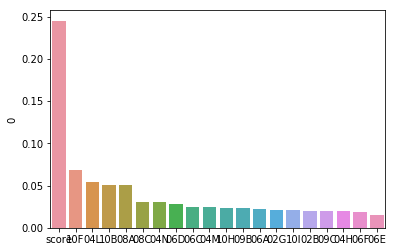

In [360]:
imp = pd.DataFrame(model.feature_importances_, index=xs)
imp.sort_values(0, ascending=False, inplace=True)
imp = imp[:20]
sns.barplot(x=imp.index,y=0,data=imp);

In [278]:
violation_dictionary['04L']

"Evidence of mice or live mice present in facility's food and/or non-food areas."

In [216]:
df['early'].sum()/len(df[(df['bin']=='cyc_init_0') & (df['event']==1)])

0.239228272096798

In [99]:
df['was_closed']=df['action'].str.contains('losed')
df['was_closed'].value_counts()

False    213379
True       4398
Name: was_closed, dtype: int64

In [ ]:
# df.reset_index(drop=True,inplace=True)
# prev_score = [np.nan]
# for i in range(1,len(df)):
#     current = df.loc[i,'camis']
#     previous = df.loc[i-1,'camis']
    
#     if current == previous:
#         previous_score = df.loc[i-1,'score']
#         prev_score.append(previous_score)
#     else:
#         prev_score.append(np.nan)
        
# new_series = pd.Series(prev_score)
# df['prev_score'] = new_series

In [ ]:
# df.to_csv('./assets/quickstart.csv')

In [2]:
# df = pd.read_csv('./assets/quickstart.csv')

C:\Users\a\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# df.drop('Unnamed: 0',axis=1,inplace=True)

In [171]:
dfa = pd.read_csv('./assets/DOHMH_New_York_City_Restaurant_Inspection_Results_historical.csv')
dfb = pd.read_csv('./assets/DOHMH_New_York_City_Restaurant_Inspection_Results_02_21_19.csv')
frames = [dfa,dfb]
df_viol = pd.concat(frames)

In [172]:
df_viol.drop_duplicates(subset='VIOLATION CODE', inplace=True)
df_viol.reset_index(drop=True, inplace=True)

In [173]:
df_viol = df_viol[['VIOLATION CODE','CRITICAL FLAG']]

In [174]:
violations = []
critical = []
for i in range(len(df_viol)):
    violations.append(df_viol.loc[i,'VIOLATION CODE'])
    critical.append(df_viol.loc[i,'CRITICAL FLAG'])
    
violation_critical_dic = dict(zip(violations, critical))

In [176]:
for i in df['codes'][:10]:
    x = i.replace("'","")
    x = x.replace('[',"")
    x = x.replace(']',"")
    x = x.replace(' ','')
    x = x.split(',')
    print(x)
    size = len(x)
    

AttributeError: 'list' object has no attribute 'replace'

In [177]:
df['critical_flag'] = ((df['codes'].str.contains('02')) | \
(df['codes'].str.contains('03')) | \
(df['codes'].str.contains('04')) | \
(df['codes'].str.contains('05')) | \
(df['codes'].str.contains('06')) | \
(df['codes'].str.contains('07')) )

In [ ]:
X = df[['1','2','3','4','5','6','7','8','9','missing_prior_cycle','missing_prior_pre','weird_cycle',\
        'weird_pre','event','time_til','critical_flag']]
# y = df['time_til']

from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(X, 'time_til', event_col='event')
cph.print_summary()

In [ ]:
r = cph.compute_residuals(X, 'deviance')
r.head()

In [ ]:
r.plot.scatter(
    x='time_til', y='deviance', c=np.where(r['event'], '#008fd5', '#fc4f30'),
    alpha=0.75
)

In [ ]:
censored_subjects = df.loc[df['event']==0]
unconditioned_sf = cph.predict_survival_function(censored_subjects)
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[df.loc[c.name, 'time_til']]).clip_upper(1))
unconditioned_sf

In [ ]:
unconditioned_sf
df.loc[72,:]

In [ ]:
from lifelines.utils import median_survival_times, qth_survival_times
subject = 72
unconditioned_sf[subject].plot(ls="--", color="#A60628", label="unconditioned")
conditioned_sf[subject].plot(color="#A60628", label="conditioned on $T>351$")

predictions_50 = median_survival_times(conditioned_sf)
predictions_75 = qth_survival_times(0.75, conditioned_sf)

plt.hlines([0.5, 0.75], 0, 550, alpha=0.5, label="percentiles")

plt.scatter(median_survival_times(conditioned_sf[subject]), 0.5,  color="#E24A33", label="median prediction", zorder=20)
plt.scatter(qth_survival_times(0.75, conditioned_sf[subject]), 0.75,  color="#467821", label="q=75 prediction", zorder=20)
            
            
plt.legend();



In [ ]:
# df[df['dba'].str.contains('Ice House')]
df[df['camis']==50088228].tail(1).iloc[0,:]
# df[df['camis']==41323299].tail(1)

=========================================================

In [ ]:
df = df[df['bin'].notnull()]

In [ ]:
df.reset_index(drop=True,inplace=True)
prev_score = [np.nan]
for i in range(1,len(df)):
    current = df.loc[i,'camis']
    previous = df.loc[i-1,'camis']
    
    if current == previous:
        previous_score = df.loc[i-1,'score']
        prev_score.append(previous_score)
    else:
        prev_score.append(np.nan)
        
new_series = pd.Series(prev_score)
df['prev_score'] = new_series

In [ ]:
for i in df.loc[107495,'codes']:
    print(violation_dictionary[i])
    print('')

In [ ]:
with_prev = df[df['prev_score'].notnull()]
# with_prev['prev_score'].corr(with_prev['time_til'])
# sns.scatterplot(with_prev['prev_score'],with_prev['time_til'])
# sns.scatterplot(with_prev[with_prev['bin']==3]['prev_score'],with_prev[with_prev['bin']==3]['time_til'])
df[df['bin']==5]
df[df['camis']==41645448]

In [ ]:
df['day_of_week'] = df['inspection_date'].dt.dayofweek

In [ ]:
day_of_week = df.groupby(['day_of_week'])['camis'].count()
sns.distplot(day_of_week);
# day_of_week.values

In [ ]:
daily_inspections = df.groupby(['inspection_date'])['camis'].count()
daily_inspections
# sns.lineplot(daily_inspections.keys(),daily_inspections.values);

In [ ]:
bin_dummies = pd.get_dummies(df['bin'], drop_first=True)
df = df.join(bin_dummies).drop('bin', axis=1)

In [ ]:
X = df[[1,2,3,4,5,6,7,8,9,10,'score','event','time_til']]
y = df['time_til']

from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(X, 'time_til', event_col='event')
cph.print_summary()

In [ ]:
cph.plot()

In [ ]:
data = df[df['inspection_date']>'2018-01-01']

In [ ]:
X = data[['1','2','3','4','5','6','7','8','9','missing_prior_cycle','missing_prior_pre','weird_cycle',\
        'weird_pre','event','time_til','critical_flag']]
# y = df['time_til']

from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(X, 'time_til', event_col='event')
cph.print_summary()

In [ ]:
censored_subjects = data.loc[data['event']==0]
unconditioned_sf = cph.predict_survival_function(censored_subjects)
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[data.loc[c.name, 'time_til']]).clip_upper(1))
unconditioned_sf

In [ ]:
from lifelines.utils import median_survival_times, qth_survival_times
subject = 72
unconditioned_sf[subject].plot(ls="--", color="#A60628", label="unconditioned")
conditioned_sf[subject].plot(color="#A60628", label="conditioned on $T>351$")

predictions_50 = median_survival_times(conditioned_sf)
predictions_75 = qth_survival_times(0.75, conditioned_sf)

plt.hlines([0.5, 0.75], 0, 550, alpha=0.5, label="percentiles")

plt.scatter(median_survival_times(conditioned_sf[subject]), 0.5,  color="#E24A33", label="median prediction", zorder=20)
plt.scatter(qth_survival_times(0.75, conditioned_sf[subject]), 0.75,  color="#467821", label="q=75 prediction", zorder=20)
            
            
plt.legend();

In [ ]:
data.loc[72,:]

In [25]:
df['bin'].value_counts()

cyc_init_0             71328
cyc_init_1             52162
cyc_re_1               34604
cyc_re_0               15543
cyc_re_2               12419
pre_init_0              9412
pre_init_1              7180
other_cycle             4550
pre_re_1                3177
pre_re_2                2470
pre_re_0                1801
other_pre               1453
missing_prior_cycle     1263
missing_prior_pre        415
Name: bin, dtype: int64

In [53]:
early_series = df[(df['bin']=='cyc_init_0') &
   (df['time_til']<200) & (df['event']==1)
  ]['camis']
early_series.drop_duplicates(inplace=True)

C:\Users\a\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\base.py:1512: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return self._update_inplace(result)


In [63]:
early_series
random.choice(early_series.values)

41459769

In [187]:
df[df['camis']==random.choice(early_series.values)
  ][['inspection_type','score','time_til','event','bin','inspection_date','action','codes','day_of_week']]

,inspection_type,score,time_til,event,bin,inspection_date,action,codes,day_of_week
56593,Cycle Inspection / Initial Inspection,14.0,76,1,cyc_init_1,2013-05-07,Violations were cited in the following area(s).,"[04H, 02G]",1
56594,Cycle Inspection / Re-inspection,12.0,176,1,cyc_re_1,2013-07-22,Violations were cited in the following area(s).,"[04H, 06D]",0
56595,Cycle Inspection / Initial Inspection,11.0,27,1,cyc_init_0,2014-01-14,Violations were cited in the following area(s).,"[08A, 04L]",1
56596,Cycle Inspection / Re-inspection,10.0,248,1,cyc_re_0,2014-02-10,Violations were cited in the following area(s).,"[04L, 08A]",0
56597,Cycle Inspection / Initial Inspection,11.0,15,1,cyc_init_0,2014-10-16,Violations were cited in the following area(s).,"[09B, 10F, 02G]",3
56598,Cycle Inspection / Re-inspection,5.0,187,1,cyc_re_0,2014-10-31,Violations were cited in the following area(s).,[10H],4
56599,Cycle Inspection / Initial Inspection,4.0,348,1,cyc_init_0,2015-05-06,Violations were cited in the following area(s).,[09C],2
56600,Cycle Inspection / Initial Inspection,5.0,476,1,cyc_init_0,2016-04-18,Violations were cited in the following area(s).,[06C],0
56601,Cycle Inspection / Initial Inspection,28.0,65,1,cyc_init_1,2017-08-07,Violations were cited in the following area(s).,"[04L, 04H, 08A, 02G]",0
56602,Cycle Inspection / Re-inspection,27.0,181,1,cyc_re_2,2017-10-11,Violations were cited in the following area(s).,"[08A, 02G, 06C, 04L]",2


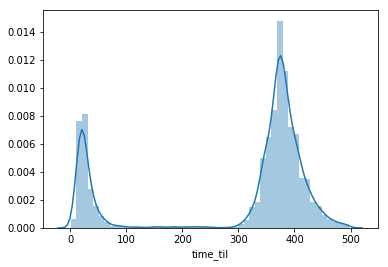

In [153]:
sns.distplot(df[(df['bin']=='cyc_init_0') &
         (df['event']==1) & 
         (df['inspection_date']>'2015-01-01') &
         (df['inspection_date']<'2016-01-01')
                              ]['time_til'])

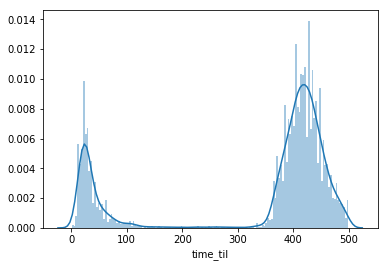

In [163]:
sns.distplot(df[(df['bin']=='cyc_init_0') &
         (df['event']==1) & 
         (df['inspection_date']>'2016-01-01') &
         (df['inspection_date']<'2017-01-01')
                              ]['time_til'], bins=150)

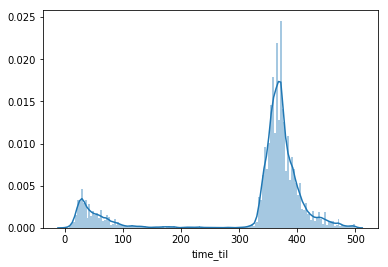

In [162]:
sns.distplot(df[(df['bin']=='cyc_init_0') &
         (df['event']==1) & 
         (df['inspection_date']>'2017-01-01') &
         (df['inspection_date']<'2018-01-01')
                              ]['time_til'], bins=150)

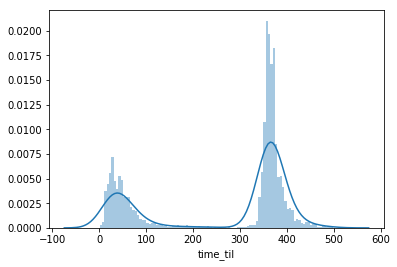

In [164]:
sns.distplot(df[(df['bin']=='cyc_init_0') &
         (df['event']==1) & 
         (df['inspection_date']>'2017-07-01') 
                              ]['time_til'],bins=100)

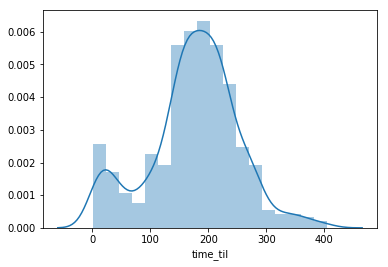

In [169]:
sns.distplot(df[df['bin']=='missing_prior_pre']['time_til'])

In [170]:
df[df['camis']==41417297][['inspection_date','score','time_til','bin','inspection_type','grade']]

,inspection_date,score,time_til,bin,inspection_type,grade
73906,2013-11-12,7.0,148,missing_prior_cycle,Cycle Inspection / Re-inspection,A
73907,2014-04-09,12.0,364,cyc_init_0,Cycle Inspection / Initial Inspection,A
73908,2015-04-08,14.0,63,cyc_init_1,Cycle Inspection / Initial Inspection,NaN
73909,2015-06-10,10.0,160,cyc_re_1,Cycle Inspection / Re-inspection,A
73910,2015-11-17,13.0,34,cyc_init_0,Cycle Inspection / Initial Inspection,NaN
73911,2015-12-21,8.0,233,cyc_re_0,Cycle Inspection / Re-inspection,A
73912,2016-08-10,28.0,56,cyc_init_1,Cycle Inspection / Initial Inspection,NaN
73913,2016-10-05,18.0,240,cyc_re_2,Cycle Inspection / Re-inspection,B
73914,2017-06-02,8.0,343,cyc_init_0,Cycle Inspection / Initial Inspection,A
73915,2018-05-11,10.0,317,cyc_init_0,Cycle Inspection / Initial Inspection,A


DAY OF THE WEEK

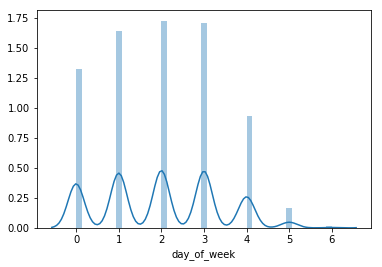

In [11]:
sns.distplot(df[df['inspection_type'].str.contains('Pre')]['day_of_week'])

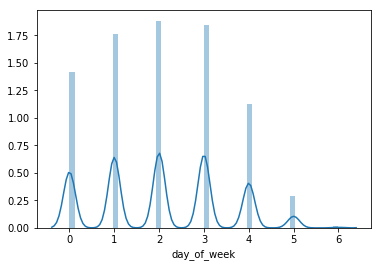

In [12]:
sns.distplot(df[df['inspection_type'].str.contains('Cycle')]['day_of_week'])

In [7]:
dow_dic = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
total = len(df)


AttributeError: 'int' object has no attribute 'index'

In [12]:
df['day_of_week'].value_counts()/total

2    0.226408
3    0.222414
1    0.212055
0    0.170653
4    0.133628
5    0.033259
6    0.001583
Name: day_of_week, dtype: float64

INSPECTOR INSPECTOR HYPOTHESIS

In [24]:
df[(df['event']==1)&
   (df['1']==1)]

,Unnamed: 0,camis,dba,boro,zipcode,phone,cuisine_description,inspection_date,action,score,...,6,7,8,9,missing_prior_cycle,missing_prior_pre,weird_cycle,weird_pre,day_of_week,prev_score
0,0,30075445,Morris Park Bake Shop,Bronx,10462.0,7188924968,Bakery,2013-08-14 00:00:00.000000000,Violations were cited in the following area(s).,32.0,...,0,0,0,0,0,0,0,0,2,NaN
9,9,30112340,Wendy'S,Brooklyn,11225.0,7182875005,Hamburgers,2014-11-13 00:00:00.000000000,Violations were cited in the following area(s).,14.0,...,0,0,0,0,0,0,0,0,3,23.0
14,14,30112340,Wendy'S,Brooklyn,11225.0,7182875005,Hamburgers,2016-10-03 00:00:00.000000000,Violations were cited in the following area(s).,48.0,...,0,0,0,0,0,0,0,0,0,13.0
34,34,40356151,Brunos On The Boulevard,Queens,11369.0,7183350505,American,2014-10-03 00:00:00.000000000,Violations were cited in the following area(s).,19.0,...,0,0,0,0,0,0,0,0,4,10.0
40,40,40356483,Wilken'S Fine Food,Brooklyn,11234.0,7184443838,Delicatessen,2013-07-09 00:00:00.000000000,Violations were cited in the following area(s).,23.0,...,0,0,0,0,0,0,0,0,1,NaN
65,65,40359705,Nathan'S Famous,Brooklyn,11224.0,7183332202,Hotdogs,2015-04-01 00:00:00.000000000,Violations were cited in the following area(s).,18.0,...,0,0,0,0,0,0,0,0,2,11.0
67,67,40359705,Nathan'S Famous,Brooklyn,11224.0,7183332202,Hotdogs,2015-08-20 00:00:00.000000000,Violations were cited in the following area(s).,25.0,...,0,0,0,0,0,0,0,0,3,11.0
69,69,40359705,Nathan'S Famous,Brooklyn,11224.0,7183332202,Hotdogs,2016-06-01 00:00:00.000000000,Violations were cited in the following area(s).,19.0,...,0,0,0,0,0,0,0,0,2,11.0
73,73,40360045,Seuda Foods,Brooklyn,11223.0,7183751500,Jewish/Kosher,2014-10-20 00:00:00.000000000,Violations were cited in the following area(s).,23.0,...,0,0,0,0,0,0,0,0,0,NaN
75,75,40360045,Seuda Foods,Brooklyn,11223.0,7183751500,Jewish/Kosher,2015-03-18 00:00:00.000000000,Violations were cited in the following area(s).,40.0,...,0,0,0,0,0,0,0,0,2,11.0


In [20]:
df.columns

Index(['Unnamed: 0', 'camis', 'dba', 'boro', 'zipcode', 'phone',
       'cuisine_description', 'inspection_date', 'action', 'score', 'grade',
       'grade_date', 'record_date', 'inspection_type', 'address', 'key',
       'codes', 'time_til', 'event', 'season', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', 'missing_prior_cycle', 'missing_prior_pre',
       'weird_cycle', 'weird_pre', 'day_of_week', 'prev_score'],
      dtype='object')